In [6]:
import pandas as pd
import numpy as np
from pandas import DataFrame
from qmplot import manhattanplot
from qmplot import qqplot
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import fdrcorrection
from statsmodels.stats.multitest import multipletests
from tqdm.auto import tqdm
import argparse
import sys

# Что нужно установить из необычных вещей, чтобы ноутбук работал:

# TASSEL Version 5.0 Standalone
# bcftools
# rpy2
# qmplot
# 

Задание:

1. Предобработка данных. Оцените качество исходного файла и проведите предобработку данных, если это необходимо. Обоснуйте свой выбор.

2. Поиск ассоциаций. Проведите GWAS анализ с использованием наиболее подходящего на ваш взгляд инструмента. Получите список значимых ассоциаций генотипа с фенотипом, визуализируйте результат.

3. Разработка модели предсказания. На основе полученных результатов предложите модель, с помощью которой можно предсказывать фенотипы на основе имеющихся данных. Оцените ее работоспособность на этих данных, предложите способы улучшения предсказательной точности модели

4. Дополнительное задание (опционально): 
- Предложите способ интеграции дополнительных данных (например, погодных условий или данных о почве) для улучшения качества предсказательной модели. 
- Опишите, как можно автоматизировать процесс анализа данных и предсказания фенотипов, используя инструменты автоматизации пайплайнов

# 1. Предобработка данных

Для начала воспользуемся bcftools stats, чтобы посмотреть на покрытие по образцам и принять решение - можем ли мы фильтровать файл по покрытию.
Посчитаем основные статистики нашего vcf файла. В частности нас будет интересовать статистика по отдельным образцам, поэтому сразу же вырежем этот кусочек из файла stats.txt. Новый файл назовем PSC.txt (Per-sample counts).

In [3]:
!pwd

/Users/lizagunko/Desktop/plastilin/work


In [192]:
%%bash
bcftools stats -s - test_data.vcf > stats.txt

In [4]:
%%bash
awk '
    $0 ~ /^# PSC, Per-sample counts/ { in_block=1; next }
    $0 ~ /^# PSI, Per-Sample Indels/  { in_block=0; next }
    in_block
' stats.txt > PSC.txt

# Если текущая строка ($0) совпадает начинается с # PSC, Per‑sample counts,
# то ставим флаг in_block = 1 (true); next -> переходим к следующей строке
# Если встречаем строку # PSI, Per-Sample Indels, то in_block=0
# и мы переходим к следующей строке
# мы выводим строки только если in_block true

In [7]:
'''
Открываем файл PSC.txt
Откруглям avgDepth до целого числа, чтобы симпатичнее получился график в дальнейшем.
'''
cols = ["tag","id","sample","nRefHom","nNonRefHom","nHets",
        "nTransitions","nTransversions","nIndels","avgDepth",
        "nSingletons","nHapRef","nHapAlt","nMissing"]

stats_for_each_sample = pd.read_csv('PSC.txt', sep='\t', comment='#', names=cols)

stats_for_each_sample['avgDepth'] = stats_for_each_sample['avgDepth'].round(0)

stats_for_each_sample

,tag,id,sample,nRefHom,nNonRefHom,nHets,nTransitions,nTransversions,nIndels,avgDepth,nSingletons,nHapRef,nHapAlt,nMissing
0,PSC,0,PS000025,12865,4674,2208,2143,4733,415,13.0,0,0,0,989
1,PSC,0,PS000026,9492,3495,2213,1824,3881,356,5.0,0,0,0,5747
2,PSC,0,PS000027,11956,4517,2496,2170,4842,402,12.0,0,0,0,1819
3,PSC,0,PS000028,10604,2934,6508,2920,6526,520,25.0,0,0,0,328
4,PSC,0,PS000030,12654,4935,2344,2244,5033,471,19.0,0,0,0,630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,PSC,0,PS000571,12636,5319,1987,2248,5052,477,30.0,0,0,0,708
149,PSC,0,PS000572,12250,5658,1992,2285,5365,477,34.0,0,0,0,622
150,PSC,0,PS000573,12387,5544,2051,2323,5269,440,31.0,0,0,0,723
151,PSC,0,PS000574,12423,5701,2042,2343,5398,477,33.0,0,0,0,376


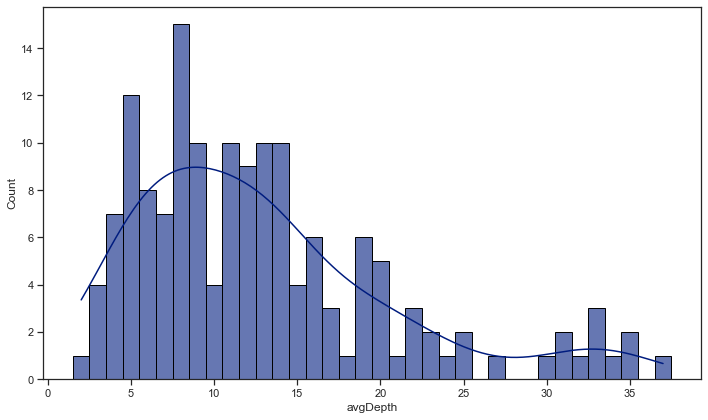

In [21]:
sns.set_theme(context='notebook', style='ticks', palette='dark', font='sans-serif', font_scale=1, color_codes=True, rc=None)

fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data=stats_for_each_sample, 
             x="avgDepth",
             edgecolor='black', 
             discrete=True,
             alpha=0.6,
             kde=True,
             ax=ax)

fig.tight_layout()
plt.savefig('depth_stats.png', dpi=200, facecolor='white')

Из этого распределения становится понятно, что по покрытию мы не можем фильтровать файл. 
Тут покрытие и так низкое. Если бы пик распределения был смещен вправо, можно было бы. 
Но в нашем случае мы потеряем много снипов, если поставим порог хотя бы = 3. 

#### Теперь откроем сам VCF файл и посмотрим на него. После этого решим, что будем с ним делать. 

In [201]:
vcf_file = "test_data.vcf"

header = []
header_idx = None

with open(vcf_file) as fh:
    for i, line in enumerate(fh):
        header.append(line)
        if line.startswith("#CHROM"):
            header_idx = i
            break
if header_idx is None:
    sys.exit("ERROR: #CHROM header line not found.")           
            

vcf_df = pd.read_csv(
    vcf_file,
    sep="\t",
    skiprows=header_line,       # skip all lines BEFORE #CHROM
    header=0,                   # this first non-skipped line is the header
    dtype=str                   # load everything as string first
)

vcf_df = vcf_df.rename(columns=lambda c: c.lstrip("#"))
vcf_df

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,PS000025,...,PS000566,PS000567,PS000568,PS000569,PS000570,PS000571,PS000572,PS000573,PS000574,PS000575
0,1,40481,.,G,A,132.0,.,.,GT:PL:DP,"0/1:10,0,87:9",...,"0/0:0,66,250:22","0/0:0,47,247:20","0/0:0,99,251:33","0/0:0,39,255:13","0/0:0,60,250:20","0/0:0,48,246:16","0/0:0,48,234:16","0/0:0,75,255:25","0/0:0,42,255:14","0/0:0,63,249:21"
1,1,40522,.,C,T,999.0,.,.,GT:PL:DP,"0/1:33,0,95:10",...,"0/0:0,66,196:22","0/0:0,47,193:20","0/0:0,99,199:33","0/0:0,36,182:12","0/0:0,57,195:19","0/0:0,48,192:16","0/0:0,51,194:17","0/0:0,75,198:25","0/0:0,42,189:14","0/0:0,63,196:21"
2,1,111641,.,G,C,999.0,.,.,GT:PL:DP,"0/0:0,3,40:1",...,"0/1:255,0,223:56","0/0:0,21,254:7","0/1:255,0,194:37","0/1:255,0,222:40","0/0:0,39,255:13","0/0:0,39,255:13","0/0:0,15,212:5","0/1:255,0,141:29","0/0:0,24,255:8","0/1:255,0,164:31"
3,1,111675,.,G,C,999.0,.,.,GT:PL:DP,"0/0:0,3,60:1",...,"0/1:255,0,221:56","0/0:0,21,254:7","0/1:255,0,229:38","0/1:255,0,222:40","0/0:0,39,255:13","0/0:0,39,255:13","0/0:0,15,206:5","0/1:255,0,141:29","0/0:0,24,255:8","0/1:255,0,164:31"
4,1,111688,.,T,C,999.0,.,.,GT:PL:DP,"0/0:0,3,60:1",...,"0/1:255,0,223:56","0/0:0,21,254:7","0/1:255,0,226:38","0/1:255,0,222:40","0/0:0,39,255:13","0/0:0,39,255:13","0/0:0,15,212:5","0/1:255,0,141:29","0/0:0,24,255:8","0/1:255,0,164:31"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21908,20,34703330,.,C,A,999.0,.,.,GT:PL:DP,"1/1:206,42,0:14",...,"1/1:204,132,0:44","1/1:198,81,0:27","0/0:0,69,197:23","1/1:199,96,0:32","1/1:198,81,0:27","0/0:0,57,193:20","1/1:189,42,0:14","1/1:198,75,0:25","1/1:198,81,0:27","1/1:198,84,0:28"
21909,20,34703365,.,G,C,999.0,.,.,GT:PL:DP,"0/0:0,42,205:14",...,"1/1:255,132,0:44","0/0:0,81,255:27","0/0:0,72,255:24","0/0:0,96,255:32","0/0:0,81,255:27","0/0:0,60,255:20","0/0:0,5,230:14","0/0:0,72,255:24","0/0:0,81,255:27","0/0:0,84,255:28"
21910,20,34703765,.,T,G,999.0,.,.,GT:PL:DP,"1/1:99,9,0:3",...,"1/1:143,18,0:6","0/1:0,3,37:1","0/0:0,21,154:7","0/0:0,18,143:6","0/0:0,30,175:10","0/0:0,6,67:2","1/1:92,9,0:3","0/0:0,18,143:6","1/1:92,9,0:3","1/1:129,15,0:5"
21911,20,34703921,.,T,A,999.0,.,.,GT:PL:DP,"1/1:91,9,0:3",...,"0/0:0,18,143:6","0/1:0,3,37:1","0/0:0,21,154:7","0/0:0,18,138:6","0/0:0,30,175:10","0/0:0,6,67:2","1/1:92,9,0:3","0/0:0,18,138:6","1/1:92,9,0:3","1/1:113,12,0:4"


Здесь нет FORMAT/GQ, а вообще это хорошая метрика, по которой можно было бы фильтровать снипы. 
FORMAT/GQ характеризует каждый образец отдельно, отражает "уверенность в заявленном генотипе".
То есть, например, GT = 0/1, а GQ отражает, насколько мы уверены, что это так. 
GQ рассчитывается как разность между "вероятностью" лучшего GT и "вероятностью" следующего наиболее хорошего GT.
Иными словами, "какой отрыв у лучшего GT". Если отрыв большой, это хорошо! Это значит, мы очень сильно уверены в том, что именно наш GT лучший. 
Самому лучшему GT присваивается нулевой скор в FORMAT/PL, поэтому GQ (отрыв) будет равен второму по меньшинству PL.

Посчитаем GQ для каждого снипа в каждом образце и добавим в наш VCF файл. 

In [202]:
'''
Проверим, есть ли пустые значения в столбце REF
Если есть, они нам помешают
'''

vcf_df.loc[vcf_df['REF'].isna()]



,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,PS000025,...,PS000566,PS000567,PS000568,PS000569,PS000570,PS000571,PS000572,PS000573,PS000574,PS000575
664,2,74293,.,NaN,C,999.0,.,.,GT:PL:DP,"0/1:40,3,0:1",...,"1/1:163,27,0:9","0/0:0,27,255:9","0/0:0,15,172:5","0/0:0,33,255:11","0/0:0,18,221:6","0/0:0,12,152:4","0/0:0,24,250:8","0/0:0,15,223:5","0/0:0,21,255:7","1/1:143,18,0:6"
665,2,85035,.,NaN,A,999.0,.,.,GT:PL:DP,"1/1:154,18,0:6",...,"1/1:182,42,0:14","0/0:0,27,170:9","0/0:0,63,196:21","0/0:0,42,188:14","0/0:0,39,187:13","0/0:0,9,92:3","0/0:0,27,170:9","0/0:0,6,67:2","0/0:0,9,84:3","1/1:190,45,0:15"
666,2,101067,.,NaN,TAAAAAAAAA,110.0,.,.,GT:PL:DP,"0/1:13,0,3:3",...,"1/1:41,22,1:8","0/0:0,18,43:6","0/0:0,12,35:4","0/0:0,12,33:4","0/0:0,39,45:14","0/0:0,21,45:7","0/0:0,42,45:15","0/0:0,30,48:10","0/0:0,15,34:6","1/1:45,23,0:11"
667,2,120339,.,NaN,C,999.0,.,.,GT:PL:DP,"1/1:140,15,0:5",...,"1/1:198,78,0:26","0/0:0,51,194:17","0/0:0,60,195:20","0/0:0,84,198:28","0/0:0,57,195:19","0/0:0,48,192:16","0/0:0,57,195:19","0/0:0,60,195:20","0/0:0,42,189:14","1/1:189,42,0:14"
668,2,157840,.,NaN,G,999.0,.,.,GT:PL:DP,"1/1:255,102,0:34",...,"0/0:0,3,60:1","0/0:0,255,255:97","0/0:0,255,255:111","0/0:0,255,255:91","0/0:0,255,255:116","0/0:0,190,255:63","0/0:0,255,255:110","0/0:0,255,255:100","0/0:0,255,255:99","0/0:0,255,255:104"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21634,20,20725462,.,NaN,C,258.0,.,.,GT:PL:DP,"0/0:0,4,2:7",...,"0/0:0,45,97:15","0/0:0,13,45:28","0/0:0,60,60:20","0/0:0,39,11:13","0/0:0,30,12:23","0/1:15,3,0:39","0/0:0,32,37:35","0/0:0,12,11:4","0/0:0,57,54:19","0/0:0,22,75:22"
21635,20,20772854,.,NaN,G,999.0,.,.,GT:PL:DP,"0/1:40,3,0:1",...,"0/1:138,0,114:14","0/1:79,0,53:5","0/1:116,0,129:13","0/1:139,0,100:13","0/1:118,0,118:12","0/1:25,0,81:4","0/1:91,0,109:9","0/1:77,0,77:6","0/1:16,0,125:7","0/1:30,0,153:13"
21636,20,20772902,.,NaN,G,999.0,.,.,GT:PL:DP,"0/1:40,3,0:1",...,"0/1:245,0,207:14","0/1:125,0,96:5","0/1:209,0,230:13","0/1:243,0,183:13","0/1:211,0,211:12","0/1:48,0,140:4","0/1:163,0,192:9","0/1:135,0,135:6","0/1:39,0,218:7","0/1:62,0,255:13"
21637,20,20772945,.,NaN,A,999.0,.,.,GT:PL:DP,"0/1:39,3,0:1",...,"0/1:245,0,207:14","0/1:137,0,96:5","0/1:209,0,230:13","0/1:246,0,183:13","0/1:211,0,211:12","0/1:36,0,140:4","0/1:163,0,192:9","0/1:135,0,135:6","0/1:39,0,218:7","0/1:62,0,255:13"


В столбце REF есть NaN, это плохо. 
Непонятно, откуда они взялись. 
Бывает такое, что неправильно записаны инсерции. Например, в строке 666 такой случай: 	NaN	TAAAAAAAAA
Произошла инсерция, и в ALT записана последовательность инсерции. 
По правилам, в REF должна быть записана последняя буква до инсерции, а в ALT -  последняя буква до инсерции + инсерция.
Однако в нашем файле есть и такие строки, где простой однобуквенный полиморфизм, а в REF пусто. 
Эту проблему можно было бы аккуратно починить, имея референсный геном. 
У нас нет референсного генома, поэтому будем решать проблему неаккуратно:
когда отсутствует значение в столбце REF, то подставим туда первую букву из ALT.


In [203]:
'''
Функция append_gq выделяет второй по меньшинству GQ из строки GT:PL:DP и записывает значение в конец строки
Получается GT:PL:DP:GQ
'''

def append_gq(geno_str):
    # например geno_str: "1/1:255,81,0:27"
    parts = geno_str.split(":")              
    pl_vals = sorted(int(x) for x in parts[1].split(","))
    gq = pl_vals[1]                           
    parts.append(str(gq))
    return ":".join(parts)


# вместо пропущенных генотипов в REF вставим первый символ из ALT

mask = vcf_df["REF"].isna()  
vcf_df.loc[mask, "REF"] = vcf_df.loc[mask, "ALT"].str[0]

# запишем sample_columns
fmt_col = "FORMAT"
sample_columns = vcf_df.columns[vcf_df.columns.get_loc(fmt_col) + 1 :]

# к каждой колонке с сэмплами применим функцию append_gq
# в колонку формат допишем, что у нас теперь есть ещё GQ

for col in sample_columns:
    vcf_df[col] = vcf_df[col].apply(append_gq)

vcf_df[fmt_col] = vcf_df[fmt_col].astype(str) + ":GQ"

'''
Добавим в хедер строку ##FORMAT=<ID=GQ,Number=1,Type=Integer,Description="Genotype Quality"
Поскольку если FORMAT/GQ появился в таблице, то и в хедере должна появиться соответствующая пометка
'''

for idx, line in enumerate(header):
    if line.startswith('##FORMAT=<ID=GT'):
        header.insert(idx+1, '##FORMAT=<ID=GQ,Number=1,Type=Integer,Description="Genotype Quality">' + "\n")
        
'''
Соединим отредактированный хедер с обновленной таблицей и сохраним как файл test_data_revised.vcf
'''

with open('test_data_revised.vcf', "w") as out:
    out.writelines(header)                   
    vcf_df.to_csv(out, sep="\t", index=False, header=False)
    
# Чтобы представить файл test_data_revised.vcf в репозитории, его пришлось заархивировать
# разархивировать можно такой командой
# bgzip -d test_data_revised.vcf.gz 

In [71]:
%%bash
bcftools filter -e "FORMAT/GQ < 1" -Ov test_data_revised.vcf > test_data_revised_filt.vcf


In [72]:
%%bash
wc -l test_data_revised.vcf
wc -l test_data_revised_filt.vcf

   21958 test_data_revised.vcf
     616 test_data_revised_filt.vcf


Как-то уж слишком много строк у нас уничтожается! Дальше будем работать с файлом test_data_revised.vcf, без фильтрации по GQ.

# 2. Поиск ассоциаций
Здесь нам понадобится программа TASSEL Version 5.0 Standalone (https://tassel.bitbucket.io/). Работаем в папке ./step2_gwas

Подготовим файл с фенотипами test_data.tsv
Его надо изменить, добавив в хедер слово Trait

In [ ]:
%%bash
awk 'NR==1{$1="<Trait>"}1' OFS="\t" ../test_data.tsv > ./trait_data.tsv


In [ ]:
%%bash

perl ./tassel-5-standalone/run_pipeline.pl -Xms5g -Xmx250g -vcf test_data_revised.vcf -sortPositions -export test_data -exportType Hapmap

perl ./tassel-5-standalone/run_pipeline.pl -Xms5g -Xmx250g -importGuess test_data.hmp.txt -sortPositions -FilterSiteBuilderPlugin -siteMinAlleleFreq 0.05 -endPlugin -export variants_filt -exportType Hapmap 

perl ./tassel-5-standalone/run_pipeline.pl -Xms5g -Xmx250g -importGuess variants_filt1.hmp.txt -sortPositions -KinshipPlugin -method Centered_IBS -endPlugin -export kinship.txt -exportType SqrMatrix


perl ./tassel-5-standalone/run_pipeline.pl -Xms5g -Xmx250g -importGuess variants_filt1.hmp.txt -sortPositions -PrincipalComponentsPlugin -covariance true -endPlugin -export PCA

perl ./tassel-5-standalone/run_pipeline.pl -Xms5g -Xmx250g -fork1 -importGuess ./variants_filt1.hmp.txt -sortPositions -fork2 -importGuess ./trait_data.tsv -fork3 -importGuess ./kinship.txt -excludeLastTrait -combine5 -input1 -input2 -input3 -intersect -FixedEffectLMPlugin -endPlugin -export ./glm_output

# ИЛИ если мы хотим MLM, то используем команду ниже

# perl run_pipeline.pl -Xms5g -Xmx250g -fork1 -importGuess variants_filt1.hmp.txt -sortPositions -fork2 -importGuess trait_data.txt -fork3 -importGuess PCA1.txt -fork4 -importGuess kinship.txt \
# -combine5 -input1-input2 -input3 -intersect -combine6 -input5 -input4 -mlm -mlmVarCompEst P3D -mlmCompressionLevel Optimum -export mlm_output


### GLM (General/Fixed‑Effect Linear Model)
y=α+Xγ+gβ, 
α - интрерсепт
𝛾 - ковариаты 
β - эффекты генотипов

### MLM (Mixed Linear Model)
y=α+Xγ+gβ+u+ε,, 
где α+Xγ+gβ это те же fixed‑effects, что и в GLM (SNP, PC)
u - это random effect: ковариационная матрица K (киншип). K входит внутрь u


In [243]:
my_glm = pd.read_csv('glm_output1.txt', sep='\t', index_col=0)
my_glm

,Marker,Chr,Pos,marker_F,p,marker_Rsq,add_F,add_p,dom_F,dom_p,marker_df,marker_MS,error_df,error_MS,model_df,model_MS,minorObs
Trait,,,,,,,,,,,,,,,,,
phenotype,S1_40481,1,40481,0.85289,0.43012,0.02140,1.41045,0.238540,0.30770,0.58068,2,155.86894,78,182.75296,2,155.86894,22
phenotype,S1_40522,1,40522,2.26706,0.10957,0.04848,3.87863,0.051980,0.66972,0.41534,2,366.27649,89,161.56487,2,366.27649,34
phenotype,S1_111641,1,111641,0.36821,0.69304,0.00839,0.73110,0.394850,0.01352,0.90769,2,59.48577,87,161.55320,2,59.48577,25
phenotype,S1_111675,1,111675,0.36821,0.69304,0.00839,0.73110,0.394850,0.01352,0.90769,2,59.48577,87,161.55320,2,59.48577,25
phenotype,S1_111688,1,111688,0.36821,0.69304,0.00839,0.73110,0.394850,0.01352,0.90769,2,59.48577,87,161.55320,2,59.48577,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
phenotype,S20_34703330,20,34703330,6.03116,0.00343,0.11373,12.18357,0.000733,0.00619,0.93744,2,884.90766,94,146.72274,2,884.90766,17
phenotype,S20_34703365,20,34703365,0.05052,0.95077,0.00107,0.07786,0.780820,0.02397,0.87729,2,8.35382,94,165.37282,2,8.35382,4
phenotype,S20_34703765,20,34703765,0.95717,0.38916,0.02778,1.50578,0.224020,0.42138,0.51847,2,156.21825,67,163.20798,2,156.21825,14


In [285]:
my_glm[my_glm['p']<=0.05]

,Marker,Chr,Pos,marker_F,p,marker_Rsq,add_F,add_p,dom_F,dom_p,marker_df,marker_MS,error_df,error_MS,model_df,model_MS,minorObs,p_FDR_BH,signif_FDR_0.05
Trait,,,,,,,,,,,,,,,,,,,
phenotype,S1_384882,chr1,384882,3.91650,0.024350,0.09936,0.53271,0.467840,7.254030,0.00882,2,624.62194,71,159.48457,2,624.62194,24,0.473313,False
phenotype,S1_5780803,chr1,5780803,3.48363,0.035620,0.08298,6.38647,0.013520,0.612520,0.43624,2,509.61944,77,146.28975,2,509.61944,21,0.529924,False
phenotype,S1_6389605,chr1,6389605,4.34532,0.016530,0.10770,8.29126,0.005220,0.460650,0.49950,2,686.04535,72,157.88133,2,686.04535,22,0.417758,False
phenotype,S1_6517814,chr1,6517814,3.19921,0.046420,0.07861,5.64227,0.020050,0.773000,0.38210,2,505.04348,75,157.86499,2,505.04348,26,0.558998,False
phenotype,S1_6888441,chr1,6888441,3.58921,0.032970,0.09549,6.81661,0.011070,0.419190,0.51952,2,532.35253,68,148.32020,2,532.35253,12,0.523427,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
phenotype,S20_34627298,chr20,34627298,3.96027,0.022510,0.08172,8.00952,0.005740,0.000017,0.99674,2,594.03194,89,149.99769,2,594.03194,17,0.459640,False
phenotype,S20_34653751,chr20,34653751,8.44469,0.000587,0.21966,16.61753,0.000134,0.427750,0.51559,2,1257.29600,60,148.88590,2,1257.29600,10,0.110964,False
phenotype,S20_34676147,chr20,34676147,4.19186,0.018170,0.08521,8.38712,0.004730,0.081270,0.77623,2,565.57115,90,134.92136,2,565.57115,14,0.429572,False


Мы получили главный результат GWAS - это таблица с вариантами, которые были проанализированы.
Каждому варинату была присвоена вероятности ассоциации с фенотипом. 
Не все эти варианты оказались значимо ассоциированы, нам нужно сделать поправку 
на множественное тестирование и посмотреть, какие снипы проходят по уровню значимости. 

Кроме того, мы хотим визуализировать результат - построить Manhattan и QQ-plot. 
Мы сделаем это с помощью пакета qmplot (https://github.com/ShujiaHuang/qmplot).

Для удобства уменьшим нашу таблицу до четырех столбцов:  #CHROM, POS, P, ID

Мы сделаем графики c raw p-val и c p_FDR, посмотрим на них и сравним результат.  

In [244]:

my_glm.dropna(subset=['Chr'], inplace=True)
my_glm.dropna(subset=['p'], inplace=True)


pvals = my_glm["p"].astype(float)         
rej, p_adj, *_ = multipletests(pvals, method="fdr_bh")


my_glm["p_FDR_BH"] = p_adj 
my_glm["signif_FDR_0.05"] = rej
my_glm['Chr'] = 'chr'+ my_glm['Chr'].astype(int).astype('str')

my_glm_raw_pval = my_glm.rename(columns={'Marker': 'ID', 'Pos':'POS', 'p': 'P', 'Chr': '#CHROM'})
my_glm_raw_pval = my_glm_raw_pval[['#CHROM', 'POS', 'P', 'ID']]
my_glm_raw_pval.to_csv('./my_glm_raw_pval.txt', sep = '\t', index=True)

my_glm_FDR = my_glm.rename(columns={'Marker': 'ID', 'Pos':'POS', 'p_FDR_BH': 'P', 'Chr': '#CHROM'})
my_glm_FDR = my_glm_FDR[['#CHROM', 'POS', 'P', 'ID']]
my_glm_FDR.to_csv('./my_glm_FDR.txt', sep = '\t', index=True)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


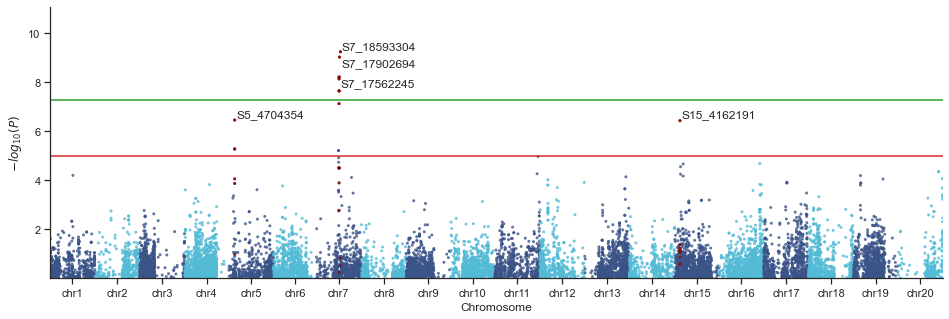

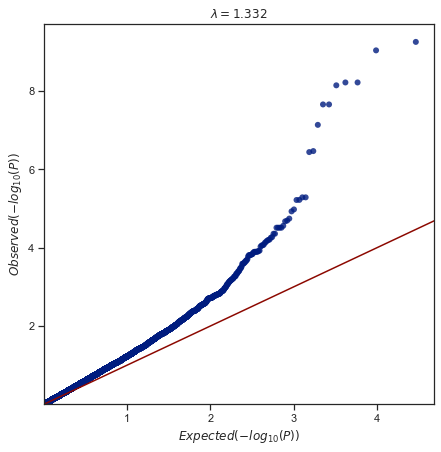

In [167]:
f, ax = plt.subplots(figsize=(16, 5), facecolor='w', edgecolor='k')
manhattanplot(data=my_glm_raw_pval, sign_marker_p=1e-6, is_annotate_topsnp=True, ax=ax)
plt.savefig("GLM_raw_pval_manhattan_plot.png", dpi=300)

f, ax = plt.subplots(figsize=(7, 7), facecolor='w', edgecolor='k')
qqplot(data=my_glm_raw_pval["P"], ax=ax)
plt.savefig("GLM_raw_pval_QQ_plot.png", dpi=300)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


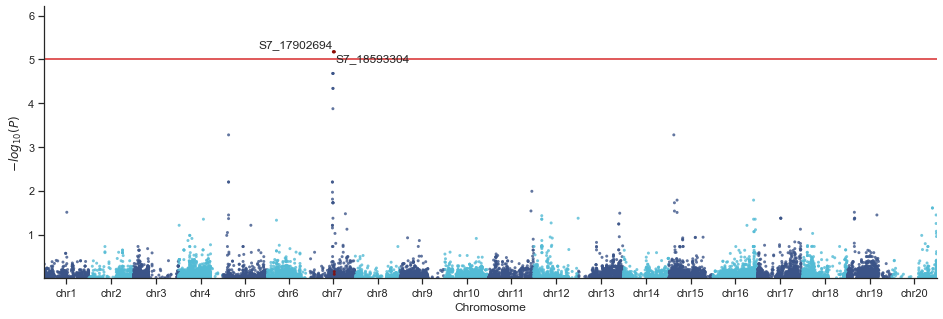

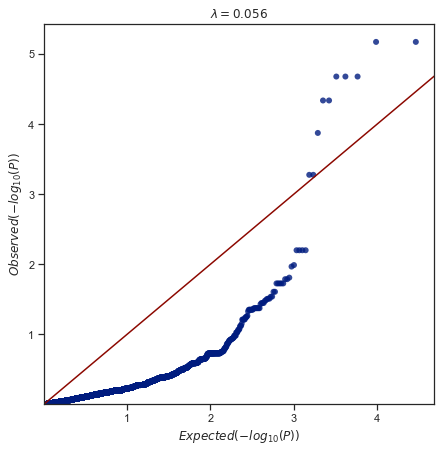

In [245]:
f, ax = plt.subplots(figsize=(16, 5), facecolor='w', edgecolor='k')
manhattanplot(data=my_glm_FDR, sign_marker_p=1e-5, is_annotate_topsnp=True, ax=ax)
plt.savefig("GLM_fdr_manhattan_plot.png", dpi=300)

f, ax = plt.subplots(figsize=(7, 7), facecolor='w', edgecolor='k')
qqplot(data=my_glm_FDR["P"], ax=ax)
plt.savefig("GLM_fdr_QQ_plot.png", dpi=300)

In [ ]:
# Можно запустить qmplot в командной строке. Тогда сделаются сразу и манхеттен и QQ
%%bash
qmplot -I my_glm_FDR.txt --top-sign-signal-mark-id ID -O glm_FDR -T qmplot_manhattan

#### Значимо ассоциированные с фенотипом варианты нашлись, это очень радует! В первую очередь стоит присмотреться к тем, которые в таблице my_glm_FDR проходят по уровню значимости. 

# 3. Разработка модели предсказания

In [574]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, mean_absolute_error

import statsmodels.api as sm


In [575]:
# разделим генотипы и таргет - таргет это фенотип - то, что мы хотим предсказывать

X = ds.drop(columns='phenotype')
y = ds['phenotype']


In [576]:
# еще чуть-чуть подготовим данные - от букв перейдем к колонкам с нулями и единицами 

categorical_cols = X.select_dtypes(include=['object', 'category']).columns

# наши данные будут записаны в объект preprocess
# как колонки с нулями и единицами, причем первую колонку мы дропнем, чтобы избавиться от избыточной информации

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols), # 
        # ('num', 'passthrough', numeric_cols)
    ]
)


# создаем узел linreg_pipe

linreg_pipe = Pipeline(steps=[
    ('preprocess', preprocess), 
    ('model', Ridge(alpha=100.0,         # модель называется Ridge
                    solver='lsqr',       # метод оптимизации
                    random_state=42,     # Как мы случайным образом делим выборку на 5 фолдов 
                    fit_intercept=False)) # ?
])

linreg_pipe.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  Index(['S1_384882', 'S1_5780803', 'S1_6389605', 'S1_6517814', 'S1_6888441',
       'S1_8170953', 'S1_9602581', 'S1_10725086', 'S1_14784953', 'S1_14790574',
       ...
       'S20_34598252', 'S20_34605571', 'S20_34605587', 'S20_34627208',
       'S20_34627224', 'S20_34627298', 'S20_34653751', 'S20_34676147',
       'S20_34703150', 'S20_34703330'],
      dtype='object', length=1269))])),
                ('model',
                 Ridge(alpha=100.0, fit_intercept=False, random_state=42,
                       solver='lsqr'))])

In [577]:
# решаем что наша модель будет опираться на rmse

rmse_scorer = make_scorer(
    mean_squared_error,
    greater_is_better=False,   # чтобы max → best, как у других neg_* scorers
    squared=False              # RMSE, а не MSE
)

# Настраиваем кросс-валидацию, хотим чтобы выборка разбивалась на пять частей рандомным но вопроизводимым образом

cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Хотя в процессе мы договорились опираться на RMSE, в конце мы хотим посмотреть и на другие метрики
scoring = {
    'r2'  : 'r2',
    'mse' : 'neg_mean_squared_error',
    'rmse': rmse_scorer,
    'mae' : 'neg_mean_absolute_error'
}

# Запускаем кросс-валидацию
cv_res = cross_validate(
    estimator = linreg_pipe,   # здесь наш пайплайн, который состоит из преобразования данных (preprocess) и самой модели (Ridge)
    X = X,
    y = y,
    scoring = scoring,
    cv = cv,
    n_jobs = -1,
    return_train_score = False
)

# Посмотрим какой получается rmse у обучившейся модели на валидационной выборке (даже на 5 валидационных выборках)
# Для каждой метрики получаем 5 чисел - берём mean() и std()

print("5‑fold CV (mean ± std):")
for key in scoring.keys():
    scores = cv_res[f'test_{key}']
    if key in {'mse', 'mae', 'rmse'}:      # отрицательные значения переводим в положительные просто для удобства
        scores = -scores
    print(f"{key.upper():<4}: {scores.mean():.4f} ± {scores.std():.4f}")
    
# mean - ожидаемая ошибка на будущем наборе из той же популяции
# std - насколько эта оценка меняется от выборки к выборке в нашей кросс-валидации

5‑fold CV (mean ± std):
R2  : -0.0907 ± 0.0871
MSE : 163.8027 ± 45.7890
RMSE: 12.6825 ± 1.7198
MAE : 9.7861 ± 0.9720


/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [47, 335, 802, 868, 869, 1254, 1255] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [53, 103, 149, 159, 169, 311, 322, 346, 347, 348, 353, 354, 366, 398, 551, 552, 553, 566, 576, 578, 579, 580, 582, 588, 643, 646, 664, 710, 711, 727, 733, 753, 757, 770, 792, 795, 799, 800, 862, 905, 1024, 1081, 1082, 1125, 1126, 1142, 1154, 1155, 1201, 1257, 1258, 1260, 1261] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [690, 691] during transform. These unknown categories will be encoded as all zeros
  warnings

Модель в среднем работает хуже, чем прогноз в виде среднего y. То есть, предсказывать просто среднее значение оказалось надёжнее, чем наша текущая Ridge‑регрессия. 
Std = 0.087 по R² и 1.7 по RMSE - большой разброс, имеет значение, какие данные попадали в тренировочную выборку
MAE = 9.8 при RMSE = 12.7 намекает на присутствие отдельных точек которые далеко от линии регрессии (RMSE «штрафует» квадратично).

In [578]:
# Посмотрим на метрики которые получаются на какой-то одной валидационной выборке 

y_pred = linreg_pipe.predict(X_val)
y_pred_train = linreg_pipe.predict(X_train)

r2_train   = r2_score(y_train, y_pred_train)
mse_train  = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
mae_train  = mean_absolute_error(y_train, y_pred_train)


r2   = r2_score(y_val, y_pred)
mse  = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_val, y_pred)

print("TRAIN")
print(f'R²   : {r2_train:.4f}')
print(f'MSE  : {mse_train:.4f}')
print(f'RMSE : {rmse_train:.4f}')
print(f'MAE  : {mae_train:.4f}')

print("VAL")
print(f'R²   : {r2:.4f}')
print(f'MSE  : {mse:.4f}')
print(f'RMSE : {rmse:.4f}')
print(f'MAE  : {mae:.4f}')

TRAIN
R²   : 0.6717
MSE  : 57.6875
RMSE : 7.5952
MAE  : 5.5910
VAL
R²   : -0.0070
MSE  : 87.3174
RMSE : 9.3444
MAE  : 7.5637


67 % дисперсии объяснено на тренировочной выборке. А на валидационной выборке модель работает хуже, чем просто среднее значение по фенотипу. Большая разница между скорами полученными на тренировочной и валидационной выборке, говорит о том, что модель переобучилась. То есть модель хорошо выучила конкретный тренировочный набор данных, но ей не хватает гибкости или регуляризации, чтобы обобщиться на новые данные. ЧТо сделать? попробовать настроить регуляризацию (это параметр альфа, штраф за высокие коэффициенты перед признаками)

# 3. Разработка модели предсказания - другой способ
 
Тут нам понадобятся два R пакета
rrBLUP (https://cran.r-project.org/web/packages/rrBLUP/index.html),
caret (https://cran.r-project.org/web/packages/caret/index.html)



In [ ]:
# Чтобы можно было код на R запускать в jupyter notebook, нужно сделать так:

# pip install rpy2
# install.packages(c("repr","IRdisplay")) - в R-studio

%load_ext rpy2.ipython # активируем rpy2 в jupyter notebook

#### Для начала подготовим данные. Для этого этапа нам нужны
1. матрица генотипов - сделаем её на основе vcf_df
2. результат запуска gwas (таблица с вариантами и p-vals) 
3. данные с фенотипами


In [204]:
vcf_df

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,PS000025,...,PS000566,PS000567,PS000568,PS000569,PS000570,PS000571,PS000572,PS000573,PS000574,PS000575
0,1,40481,.,G,A,132.0,.,.,GT:PL:DP:GQ,"0/1:10,0,87:9:10",...,"0/0:0,66,250:22:66","0/0:0,47,247:20:47","0/0:0,99,251:33:99","0/0:0,39,255:13:39","0/0:0,60,250:20:60","0/0:0,48,246:16:48","0/0:0,48,234:16:48","0/0:0,75,255:25:75","0/0:0,42,255:14:42","0/0:0,63,249:21:63"
1,1,40522,.,C,T,999.0,.,.,GT:PL:DP:GQ,"0/1:33,0,95:10:33",...,"0/0:0,66,196:22:66","0/0:0,47,193:20:47","0/0:0,99,199:33:99","0/0:0,36,182:12:36","0/0:0,57,195:19:57","0/0:0,48,192:16:48","0/0:0,51,194:17:51","0/0:0,75,198:25:75","0/0:0,42,189:14:42","0/0:0,63,196:21:63"
2,1,111641,.,G,C,999.0,.,.,GT:PL:DP:GQ,"0/0:0,3,40:1:3",...,"0/1:255,0,223:56:223","0/0:0,21,254:7:21","0/1:255,0,194:37:194","0/1:255,0,222:40:222","0/0:0,39,255:13:39","0/0:0,39,255:13:39","0/0:0,15,212:5:15","0/1:255,0,141:29:141","0/0:0,24,255:8:24","0/1:255,0,164:31:164"
3,1,111675,.,G,C,999.0,.,.,GT:PL:DP:GQ,"0/0:0,3,60:1:3",...,"0/1:255,0,221:56:221","0/0:0,21,254:7:21","0/1:255,0,229:38:229","0/1:255,0,222:40:222","0/0:0,39,255:13:39","0/0:0,39,255:13:39","0/0:0,15,206:5:15","0/1:255,0,141:29:141","0/0:0,24,255:8:24","0/1:255,0,164:31:164"
4,1,111688,.,T,C,999.0,.,.,GT:PL:DP:GQ,"0/0:0,3,60:1:3",...,"0/1:255,0,223:56:223","0/0:0,21,254:7:21","0/1:255,0,226:38:226","0/1:255,0,222:40:222","0/0:0,39,255:13:39","0/0:0,39,255:13:39","0/0:0,15,212:5:15","0/1:255,0,141:29:141","0/0:0,24,255:8:24","0/1:255,0,164:31:164"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21908,20,34703330,.,C,A,999.0,.,.,GT:PL:DP:GQ,"1/1:206,42,0:14:42",...,"1/1:204,132,0:44:132","1/1:198,81,0:27:81","0/0:0,69,197:23:69","1/1:199,96,0:32:96","1/1:198,81,0:27:81","0/0:0,57,193:20:57","1/1:189,42,0:14:42","1/1:198,75,0:25:75","1/1:198,81,0:27:81","1/1:198,84,0:28:84"
21909,20,34703365,.,G,C,999.0,.,.,GT:PL:DP:GQ,"0/0:0,42,205:14:42",...,"1/1:255,132,0:44:132","0/0:0,81,255:27:81","0/0:0,72,255:24:72","0/0:0,96,255:32:96","0/0:0,81,255:27:81","0/0:0,60,255:20:60","0/0:0,5,230:14:5","0/0:0,72,255:24:72","0/0:0,81,255:27:81","0/0:0,84,255:28:84"
21910,20,34703765,.,T,G,999.0,.,.,GT:PL:DP:GQ,"1/1:99,9,0:3:9",...,"1/1:143,18,0:6:18","0/1:0,3,37:1:3","0/0:0,21,154:7:21","0/0:0,18,143:6:18","0/0:0,30,175:10:30","0/0:0,6,67:2:6","1/1:92,9,0:3:9","0/0:0,18,143:6:18","1/1:92,9,0:3:9","1/1:129,15,0:5:15"
21911,20,34703921,.,T,A,999.0,.,.,GT:PL:DP:GQ,"1/1:91,9,0:3:9",...,"0/0:0,18,143:6:18","0/1:0,3,37:1:3","0/0:0,21,154:7:21","0/0:0,18,138:6:18","0/0:0,30,175:10:30","0/0:0,6,67:2:6","1/1:92,9,0:3:9","0/0:0,18,138:6:18","1/1:92,9,0:3:9","1/1:113,12,0:4:12"


In [225]:
'''
Нам нужно получить "облегченную" матрицу генотипов. 
Удаляем мультиаллельные сайты.
Оставляем только колонки с образцами, переводим записи генотипов в числа 0, 1 и 2. 
Вместо неопределенных генотипов "./." вставляем NaN

'''

def geno_to_number(x):
    x = np.where(x == '0/0', 0, x)
    x = np.where((x == '0/1') | (x == '1/0'), 1, x)
    x = np.where(x == '1/1', 2, x)
    
    return np.where(pd.isna(x), np.nan, x).astype(np.float64)
#    return np.where(pd.isna(x), np.nan, x).astype(np.float64)

vcf_df_tmp = vcf_df.copy()

vcf_df_tmp['CHROM_POS'] = vcf_df_tmp['CHROM'] + '_' + vcf_df_tmp['POS']
vcf_df_tmp= vcf_df_tmp[['CHROM_POS'] + list(sample_columns)]


for col in tqdm(sample_columns, desc="columns processed"):
    vcf_df_tmp[col] = vcf_df_tmp[col].str.split(":").str[0]
    

allowedSymbols = {'1', '/', '0', '.'}

lambda g: all(ch in allowedSymbols for ch in g)
mask = vcf_df_tmp[sample_columns].applymap(lambda g: all(ch in allowedSymbols for ch in g))

strict_mask = mask.all(axis=1)

monoallelic_variants_vcf = vcf_df_tmp[strict_mask]
monoallelic_variants_vcf.reset_index(inplace=True, drop=True)
monoallelic_variants_vcf[sample_columns] = monoallelic_variants_vcf[sample_columns].replace({'./.': np.nan})

for column in sample_columns:
    monoallelic_variants_vcf[column] = geno_to_number(monoallelic_variants_vcf.loc[:, column])
    
monoallelic_variants_vcf = monoallelic_variants_vcf.set_index('CHROM_POS').transpose()
monoallelic_variants_vcf.columns = 'S' + monoallelic_variants_vcf.columns
monoallelic_variants_vcf.to_csv('monoallelic_variants_vcf.tsv', sep='\t', header=True)

columns processed:   0%|          | 0/153 [00:00<?, ?it/s]

/var/folders/c_/80hh52b10tdbqszm28x7cq_w0000gn/T/ipykernel_85078/2741504140.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monoallelic_variants_vcf[sample_columns] = monoallelic_variants_vcf[sample_columns].replace({'./.': np.nan})
/var/folders/c_/80hh52b10tdbqszm28x7cq_w0000gn/T/ipykernel_85078/2741504140.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monoallelic_variants_vcf.loc[:, column] = geno_to_number(monoallelic_variants_vcf.loc[:, column])


In [226]:
monoallelic_variants_vcf

CHROM_POS,S1_40481,S1_40522,S1_111641,S1_111675,S1_111688,S1_111696,S1_111712,S1_111727,S1_111744,S1_111752,...,S20_34650808,S20_34653751,S20_34653752,S20_34676147,S20_34703150,S20_34703330,S20_34703365,S20_34703765,S20_34703921,S20_34758376
PS000025,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,0.0
PS000026,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,2.0,1.0,2.0,2.0,2.0,0.0,NaN,NaN,0.0
PS000027,0.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PS000028,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
PS000030,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PS000571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PS000572,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,0.0
PS000573,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,2.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,2.0
PS000574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,0.0


#### Сделаем weighted GBLUP, не зря же мы делали GWAS
Для этого нам пригодится таблица monoallelic_variants_vcf, файл с фенотипами test_data.tsv и файл my_glm_FDR.txt

Ключевое отличие weighted GBLUP от обычного GBLUP заключается в том, что в weighted GBLUP мы считаем, что некоторые SNP важнее других. 
Мы вводим веса для каждого маркёра которые пропорциональны уровню значимости в результатах GWAS. 

In [247]:
%%R

library(rrBLUP)
library(caret)

dfM <- read.table("monoallelic_variants_vcf.tsv",
                  header = TRUE, sep = "\t",
                  row.names = 1,
                  stringsAsFactors = FALSE,
                  check.names = FALSE,
                  fill = TRUE)
M <- as.matrix(dfM)
storage.mode(M) <- "numeric"

y <- read.table("test_data.tsv",
                header = TRUE, sep = "\t",
                stringsAsFactors = FALSE)
common <- intersect(rownames(M), y$sample)
M <- M[common, , drop = FALSE]
y <- y[match(common, y$sample), , drop = FALSE]

stopifnot(all(rownames(M) == y$sample))

phenodat <- data.frame(
  id        = y$sample,
  phenotype = y$phenotype,
  stringsAsFactors = FALSE
)

gwas <- read.table("my_glm_FDR.txt",
                   header = TRUE, sep = "\t",
                   stringsAsFactors = FALSE,
                   check.names = FALSE,
                   comment.char  = "")

names(gwas) <- sub("^#", "", names(gwas))


# Сопоставляем SNP из GWAS с колонками M


idx   <- match(gwas$ID, colnames(M)) # позиция каждого варианта
valid <- which(!is.na(idx)) # те которые есть в M
gwas2 <- gwas[valid, , drop = FALSE]  # оставляем только те которые пересекаются 
M2    <- M[ , idx[valid], drop = FALSE] # оставляем только те которые пересекаются 

stopifnot(all(gwas2$ID == colnames(M2)))


# Вес = ‑log10(p‑value), но не меньше 1e‑6

w <- pmax(1e-6, -log10(gwas2$P))


# Замещение пропусков на средние значения и очистка от мономорфных локусов
M_imp <- M2
for (j in seq_len(ncol(M_imp))) {
  mu_j <- mean(M_imp[, j], na.rm = TRUE)  # средняя доза аллеля
  M_imp[is.na(M_imp[, j]), j] <- mu_j # заменяем NA на среднее
}

# Аллельная частота (p) = средняя доза аллеля / 2
p_allele <- colMeans(M_imp) / 2
keep     <- which(p_allele > 0 & p_allele < 1)  # убираем мономорфные аллеля (p==0 или 1)
M_filt   <- M_imp[, keep, drop = FALSE]
w_filt   <- w[keep]
p2       <- p_allele[keep]


S  <- sqrt(2 * p2 * (1 - p2))
Z  <- sweep(M_filt, 2, 2 * p2, FUN = "-")
Z  <- sweep(Z,      2, S,     FUN = "/")


Z_w <- sweep(Z, 2, sqrt(w_filt), FUN = "*")

Gw <- tcrossprod(Z_w) / sum(w_filt)

stopifnot(!anyNA(Gw))
stopifnot(nrow(Gw) == ncol(Gw), nrow(Gw) == nrow(M))

set.seed(42)
folds  <- createFolds(phenodat$phenotype, k = 5)
cor.v  <- rmse.v <- numeric(length(folds))

for (i in seq_along(folds)) {
  pheno_cv <- phenodat
  pheno_cv$phenotype[folds[[i]]] <- NA
  
  fit_cv <- kin.blup(data  = pheno_cv,
                     geno  = "id",
                     pheno = "phenotype",
                     K     = Gw)
  
  pred <- fit_cv$g[folds[[i]]]
  obs  <- phenodat$phenotype[folds[[i]]]
  
  cor.v[i]  <- cor(pred, obs)
  rmse.v[i] <- sqrt(mean((pred - obs)^2))
}

cat(sprintf("Weighted-GBLUP 5-fold CV: mean r = %.3f, mean RMSE = %.2f\n",
            mean(cor.v), mean(rmse.v)))

final_w_fit <- kin.blup(data  = phenodat,
                        geno  = "id",
                        pheno = "phenotype",
                        K     = Gw)

str(final_w_fit, max.level = 1)
names(final_w_fit)

cat(sprintf("Weighted-GBLUP 5-fold CV: mean r = %.3f, mean RMSE = %.2f\n",
            mean(cor.v), mean(rmse.v)))

h2_w <- final_w_fit$Vg / (final_w_fit$Vg + final_w_fit$Ve)
cat(sprintf("h² = %.7f\n", h2_w))

Weighted-GBLUP 5-fold CV: mean r = 0.653, mean RMSE = 104.57
List of 5
 $ Vg   : num 58
 $ Ve   : num 43.6
 $ g    : num [1:99(1d)] 11.68 24.17 1.94 -3.98 -2.38 ...
  ..- attr(*, "dimnames")=List of 1
 $ resid: num [1:99] 8.3 -4.19 -0.96 -4.04 8.36 ...
 $ pred : num [1:99(1d)] 116 128 106 100 102 ...
  ..- attr(*, "dimnames")=List of 1
Weighted-GBLUP 5-fold CV: mean r = 0.653, mean RMSE = 104.57
h² = 0.5707418


#### Показатели получились лучше, чем в прошлый раз. Во всяком случае, r = 0.653 это уже более сильная корреляция. Наследумость тоже посчиталась чуточку выше h² = 0.5707418.  
Наверняка можно попробовать что-то еще, например, байесовские модели, или ML. 
но сейчас я уже не успеваю дальше подумать. Остановимся на этом!

# 4. Дополнительное задание
Предложите способ интеграции дополнительных данных (например,
погодных условий или данных о почве) для улучшения качества
предсказательной модели.

Я знаю что информацию по этому поводу надо искать по ключевому выражению GxE selection.
Если вырастить один генотип в нескольких разных средах и сделать так для каждого генотипа в выборке, то мы получим представление о том, 
1. какие среды хороши, а какие не очень
2. как взаимодействуют разные генотипы с разными средами

Мы также можем понять, какие генотипы сильно откликаются на "хорошесть" среды, а какие слабо откликаются. Допустим, есть генотип1, который плох в пустыне, но чувствует себя получше в степи и еще лучше растет на опушке леса, но неизвестно, как бы он рос в реально хороших условиях (на грядке). И есть генотип2, который в среднем лучше чем генотип1 на всех местообитаниях, и про него известно, что на грядке он растет очень хорошо. Но генотип2 не показывает такой стремительный отклик на условия среды, как генотип1 на примере пустыни, степи и опушки. У нас есть основания предполагать, что генотип1 окажется на грядке лучше, чем генотип2, который просто хорош. 

По идее, фактор среды можно добавить в наш вариант линейной модели. Для этого нужно подготовить таблицу где перечислены среды (Env1, Env2...) и условия которые этим средм соответсвуют, а потом подать ее в финальную функцию. Это будет еще один коэффициент в линейной модели и он должен увеличивать точность предсказания. Но это не будет GxE interaction. Тут среды (environments) будут рассматриваться просто как хорошие или плохие среды, добавлять точность модели, но мы не сможем оценить их взаимодействие с генотипами, используя этот подход. 

In [ ]:
%%R
it_env <- kin.blup(data  = phenodat,
                   geno  = "id",
                   pheno = "phenotype",
                   K     = G,
                   covar = as.matrix(W)[Env_index, ])